# Load raw files and importing

In [ ]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

fraud_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/Fraud_Data.csv', parse_dates=["signup_time", "purchase_time"])
ip_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/IpAddress_to_Country.csv')
credit_raw=pd.read_csv(r'D:/Projects - AI & ML/fraud-detection-project/data/raw/creditcard.csv')

# Initial Summary
Checks conducted for duplicates, missing and null values. Overviews of shape and datatypes

In [ ]:
def initial_summary(df, name):
    print(f"\n=== {name} ===")
    
    # Shape
    print("Shape:", df.shape)
    
    # Data types
    print("\nData types:")
    print(df.dtypes)

    # Check if any nulls exist (overall)
    has_nulls = df.isnull().values.any()
    print(f"\nAny null values present? {has_nulls}")
    
    # If there are nulls, list columns + counts
    if has_nulls:
        null_counts = df.isnull().sum()
        print("Nulls per column:")
        print(null_counts[null_counts > 0])
    
    # Missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Duplicate rows
    print("\nTotal duplicate rows:", df.duplicated().sum())
    
    # Preview
    print("\nFirst 5 rows:")
    display(df.head())
    
# 3. Run summary on each raw dataset
initial_summary(fraud_raw,  "Fraud Data")
initial_summary(credit_raw, "Credit-Card Data")
initial_summary(ip_raw,     "IP→Country Mapping")

Initial audit shows that credit card data has 1081 duplicate rows. Next step is to drop duplicates and align schema with the fraud table.
In the credit dataset, there is no user_id, so any repeat in Time,V1...V28, Amount, Class is almost certainly a data‐entry or merge artifact not a repeat transaction

# Handling Duplicate CC Transactions

In [ ]:
# Remove duplicates in credit_raw
print("Duplicates before:", credit_raw.duplicated().sum())

credit_raw = (
    credit_raw
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Shape after deduplication:", credit_raw.shape)
print("Duplicates after :", credit_raw.duplicated().sum())

In [ ]:
# Rename Class → class to streamline later merges and analyses in line with fraud dataset
credit_raw.rename(columns={'Class':'class'}, inplace=True)

print("Columns now:", credit_raw.columns.tolist())

In [ ]:
# Quick sanity check
print("Any nulls?            ", credit_raw.isnull().any().any())
print("Total duplicates now:", credit_raw.duplicated().sum())

# Check Class Imbalance in Raw Fraud and CC Data

In [ ]:
# Class imbalance for both datasets

def plot_class_balance(df, title, palette="Set2"):
    # Compute and print percentages
    pct = df['class'].value_counts(normalize=True).mul(100).round(2)
    print(f"{title} — Class Distribution (%):\n{pct}\n")
    
    plt.figure(figsize=(6,4))
    sns.countplot(x='class',
                  hue='class',
                  data=df,
                  palette=palette,
                  legend=False)
    plt.title(f"{title} Class Distribution")
    plt.xlabel("class")
    plt.ylabel("count")
    plt.show()

for df, name in [(fraud_raw, "Fraud Data"), (credit_raw, "Credit-Card Data")]:
    plot_class_balance(df, name)

# Geolocation Merge

In [ ]:
# 1) Convert ip_address to integer
fraud_raw['ip_int'] = fraud_raw['ip_address'].astype(int)

# 2) Prepare IP→Country map
ip_map = ip_raw[['lower_bound_ip_address','upper_bound_ip_address','country']].copy()
ip_map['lower'] = ip_map['lower_bound_ip_address'].astype(int)
ip_map = ip_map.sort_values('lower')

# 3) Merge via pd.merge_asof
fraud_geo = pd.merge_asof(
    fraud_raw.sort_values('ip_int'),
    ip_map[['lower','country']].sort_values('lower'),
    left_on='ip_int',
    right_on='lower',
    direction='backward'
).drop(columns=['lower'])

# 4) Quick look: top 10 countries
plt.figure(figsize=(6,4))
sns.countplot(
    y='country',
    data=fraud_geo,
    order=fraud_geo['country'].value_counts().nlargest(10).index,
    palette='Set3'
)
plt.title('Top 10 Countries by E-commerce Transactions')
plt.show()

- The fraud dataset has moderate imbalance — standard metrics like F1 or AUC can still be meaningful, and class weights might be enough to compensate.
- The credit-card dataset is severely skewed — this can mislead any model that predicts "legit" every time with 99% accuracy. 

# Merge dataset and check overall skew

In [ ]:
# 1. Rename target columns if needed
fraud_raw.rename(columns={'Class':'class'}, inplace=True)
credit_raw.rename(columns={'Class':'class'}, inplace=True)

# 2. Merge
full_df = pd.concat([fraud_raw, credit_raw], ignore_index=True)

# 3. Inspect combined skew
overall_pct = (
    full_df['class']
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
)
print("Combined Data — Class Distribution (%):")
print(overall_pct)

# Feature Preview

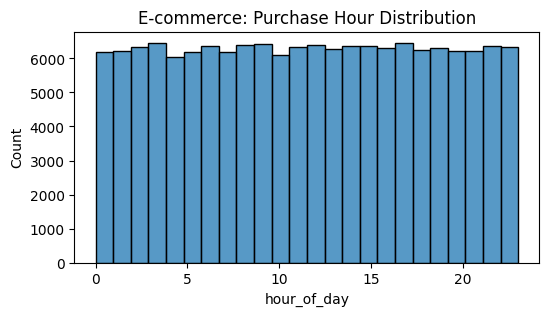

In [16]:
# Add time-based features
fraud_geo['hour_of_day']      = fraud_geo['purchase_time'].dt.hour
fraud_geo['day_of_week']      = fraud_geo['purchase_time'].dt.day_name()
fraud_geo['time_since_signup']= (
    fraud_geo['purchase_time'] - fraud_geo['signup_time']
).dt.total_seconds()

# Purchase frequency & velocity
fraud_geo = fraud_geo.sort_values(['user_id','purchase_time'])
fraud_geo['purchase_count']       = fraud_geo.groupby('user_id')['purchase_time'].transform('count')
fraud_geo['prev_purchase_time']   = fraud_geo.groupby('user_id')['purchase_time'].shift(1)
fraud_geo['time_since_prev_sec']  = (
    fraud_geo['purchase_time'] - fraud_geo['prev_purchase_time']
).dt.total_seconds()

# plot: purchase hour distribution
plt.figure(figsize=(6,3))
sns.histplot(fraud_geo['hour_of_day'], bins=24, color='C0')
plt.title('E-commerce: Purchase Hour Distribution')
plt.show()

In [21]:
# Save merged & feature-augmented fraud data for later steps
fraud_geo.to_csv('D:/Projects - AI & ML/fraud-detection-project/data/processed/fraud_geo.csv', index=False)